In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import gdal, ogr
from netCDF4 import Dataset
import rasterio
import xarray as xr
import os, os.path
from shapely.geometry import Polygon, Point, LineString

%matplotlib inline
directory = '../data'

# Read SST

In [3]:
#https://www1.ncdc.noaa.gov/pub/data/cmb/ersst/v5/netcdf/
sst = xr.open_dataset(directory+"/temp/global/ersst/ersst.v5.201805.nc").to_dataframe()
sst.reset_index(inplace=True)

#better data than above
#gathered two data points for each month (Oct - May?) to get a general feel for the temp in this growth/harvest period
filelist = os.listdir(directory+"/temp/global/oisst") 
df_list = [xr.open_dataset('../data/temp/global/oisst/'+file).to_dataframe() for file in filelist]
oisst = pd.concat(df_list)
oisst.reset_index(inplace=True)
oisst['analysed_sst'] -= 273.15
oisst.head()
print(oisst.shape)
print(min(oisst.lat), max(oisst.lat),min(oisst.lon),max(oisst.lon))
quicklook = oisst[(oisst.lat >=35) & (oisst.lat <=36) & (oisst.lon >= -124) & (oisst.lon <=-122)]
quicklook.head()

,lat,lon,nv,time,lat_bnds,lon_bnds,analysed_sst,analysis_error,mask,sea_ice_fraction
0,-89.875,-179.875,0,2017-10-31,-90.00,-180.00,NaN,NaN,2.0,NaN
1,-89.875,-179.875,1,2017-10-31,-89.75,-179.75,NaN,NaN,2.0,NaN
2,-89.875,-179.625,0,2017-10-31,-90.00,-179.75,NaN,NaN,2.0,NaN
3,-89.875,-179.625,1,2017-10-31,-89.75,-179.50,NaN,NaN,2.0,NaN
4,-89.875,-179.375,0,2017-10-31,-90.00,-179.50,NaN,NaN,2.0,NaN


In [ ]:
#create mean, max, and min temps for the data
mean_temps = oisst.groupby(['lat_bnds','lon_bnds']).mean()
max_temps = oisst.groupby(['lat_bnds','lon_bnds']).max()
min_temps = oisst.groupby(['lat_bnds','lon_bnds']).min()
mean_temps.reset_index(inplace=True)
max_temps.reset_index(inplace=True)
min_temps.reset_index(inplace=True)
max_temps['max_temp'] = max_temps.analysed_sst
min_temps['min_temp'] = min_temps.analysed_sst
#remove data cols which are useless/I don't understand
mean_temps.drop(['mask','sea_ice_fraction','analysis_error','nv'], axis=1, inplace=True)
max_temps.drop(['time','mask','sea_ice_fraction','analysed_sst','lat','lon','analysis_error','nv'],\
               axis=1, inplace=True)
min_temps.drop(['time','mask','sea_ice_fraction','analysed_sst','lat','lon','analysis_error','nv'],\
               axis=1, inplace=True)

In [ ]:
#aggregate into one big df
sst_overview = mean_temps.merge(max_temps, on=["lat_bnds","lon_bnds"], how='inner')\
                         .merge(min_temps, on=["lat_bnds","lon_bnds"], how='inner')

In [ ]:
#get values for a given point. We may want to do the kirging option instead of this.
lat = 35.863
lon = -133.72
vertices = (sst_overview.iloc[np.sqrt((sst_overview.lon_bnds-lon)**2+(sst_overview.lat_bnds-lat)**2).argsort()[:3]])
vertices.reset_index(drop=True, inplace = True)
print(vertices)
#set these to find out which row contains the closest pair along the lat/long axes.
lat_pair = None
lon_pair = None
if vertices.iloc[0].lat_bnds == vertices.iloc[1].lat_bnds:
    lat_diff = abs(vertices.iloc[0].lat_bnds - vertices.iloc[2].lat_bnds)
    lon_diff = abs(vertices.iloc[0].lon_bnds - vertices.iloc[1].lon_bnds)
    lat_pair = 1
    long_pair = 2
else:
    lat_diff = abs(vertices.iloc[0].lat_bnds - vertices.iloc[1].lat_bnds)
    lon_diff = abs(vertices.iloc[0].lon_bnds - vertices.iloc[2].lon_bnds)
    lat_pair = 2
    lon_pair = 1
print("lat_diff: {}, lon_diff: {}".format(lat_diff, lon_diff))

point_lat_diff = round(abs(vertices.iloc[0].lat_bnds - lat),2)
point_lon_diff = round(abs(vertices.iloc[0].lon_bnds - lon),2)
print("point_lat_diff: {}, point_lon_diff: {}".format(point_lat_diff, point_lon_diff))
point_lat_pct = point_lat_diff/lat_diff
point_lon_pct = point_lon_diff/lon_diff
print("point_lat_pct: {}, point_lon_pct: {}".format(point_lat_pct, point_lon_pct))

lat_temp_diff = vertices.iloc[lat_pair] - vertices.iloc[0]
lon_temp_diff = vertices.iloc[lon_pair] - vertices.iloc[0]

point_lat_temp = lat_temp_diff*point_lat_pct
point_lon_temp = lon_temp_diff*point_lon_pct
#print("poin_lat_temp: {}, point_lon_temp: {}".format(point_lat_temp, point_lon_temp))

#take into account negative temperature changes
length_fraction = (point_lat_temp + point_lon_temp)/(abs(point_lat_temp)+ abs(point_lon_temp))
point_temp = vertices.iloc[0]+length_fraction*(np.sqrt(point_lat_temp**2+point_lon_temp**2))
print(point_temp)


# Read Bathymetry

In [ ]:
bath = xr.open_dataset("../../data/bathymetry/coastal_relief_maps/crm_vol7.nc").to_dataframe()
bath.reset_index(inplace=True)
print("max x: {}, min x: {}, max y :{} min y: {}".format(max(bath.x), min(bath.x), max(bath.y), min(bath.y)))
#region = bath[(bath.x >=-121.8) & (bath.x<=-121.5) & (bath.y >=34.5) & (bath.y<=34.9)]
#region.head()

In [ ]:
region = bath[(bath.x >=-124.11) & (bath.x<=-124.10) & (bath.y >=40.0) & (bath.y<=40.3)]
region.head()
bath.shape

# Read critical species habitats

In [30]:
#read in black abalone data
#create a dictionary for reference of which species may intersect with a site
crit_species_dfs = {}
black_abalone = gpd.read_file("../data/critical/california/black_abalone/BlackAbFinalCH10272011.shp")
crit_species_dfs['black_abalone'] = black_abalone
# doesn't return any new info afaict
#babalshz = gpd.read_file("../../data/critical/california/black_abalone/BlackAbFinalCH10272011.shz")
#babalshz.head()
#site_intersections = sum(black_abalone.intersects(Polygon([[-123, 39],[-123,32],[-120,39],[-120,32]])))

leatherback = gpd.read_file("../data/critical/california/leatherback/Final_LeatherbackCH.shp")
crit_species_dfs['leatherback'] = leatherback

stellar_sealions = gpd.read_file("../data/critical/california/stellar_sealions/StellerSLionCritHab_OR_CA.shp")
crit_species_dfs['stellar_sealions'] = stellar_sealions

#green sturgeon had many shp files, most of which were irrelevant for our immediate purposes.
#I concatenated to relevant ones
#not relevant
#GreenSturgeonCHBypassAreas.shp (interior california)
#GreenSturgeonCHDepartmentofDefense.shp (not in ca)
#GreenSturgeonCHHeadOfTide.shp (interior)
#GreenSturgeonCHMarshAreas.shp (interior)
#GreenSturgeonCHStreams.shp (streams)
#GreenSturgeonCHTribalExclusions.shp

#relevant
#GreenSturgeonCHEstuaries.shp
#GreenSturgeonCHMarineCoastalZones.shp

green_sturgeon = gpd.read_file\
("../data/critical/california/green_sturgeon/GreenSturgeonFinalCH/GreenSturgeonCHEstuaries.shp")
green_sturgeon = green_sturgeon.append(gpd.read_file\
("../data/critical/california/green_sturgeon/GreenSturgeonFinalCH/GreenSturgeonCHMarineCoastalZones.shp"))
crit_species_dfs['green_sturgeon'] = green_sturgeon

In [6]:
crit_species_dfs['green_sturgeon']

,Area,CV,Conservati,Exclude,Name,Shape_Area,Shape_Leng,SpecificAr,SqKm,SqMiles,geometry
0,19.0,Medium,NaN,No,"Winchester Bay, OR",0.002411,1.499454,NaN,21.579405,8.331822,POLYGON ((-124.2068940007615 43.66733767237741...
1,11.0,High,NaN,No,"San Francisco Bay, CA",0.071543,8.101532,NaN,699.763526,270.179127,"POLYGON ((-122.533327293865 37.94285009210245,..."
2,9.0,High,NaN,No,"Suisun Bay, CA",0.013506,6.267148,NaN,131.432455,50.746152,POLYGON ((-122.0295504871151 38.24366220247759...
3,10.0,High,NaN,No,"San Pablo Bay, CA",0.033816,6.812196,NaN,329.217592,127.111114,POLYGON ((-122.2818662388755 38.30302236581031...
4,15.0,Medium,NaN,No,"Humboldt Bay, CA",0.007229,2.134222,NaN,67.719280,26.146456,POLYGON ((-124.1361448286456 40.89936367224891...
5,18.0,High,NaN,No,"Coos Bay, OR",0.005302,2.278918,NaN,47.708140,18.420142,"POLYGON ((-124.2301406397488 43.4559440703905,..."
6,22.0,Low,NaN,No,"Yaquina Bay, OR",0.001400,0.721591,NaN,12.343489,4.765829,"POLYGON ((-124.0420226403143 44.6306266798768,..."
7,24.0,Low,NaN,No,"Nehalem Bay, OR",0.000917,0.589143,NaN,7.933697,3.075537,POLYGON ((-123.8748931883716 45.73461914065132...
8,25.0,High,NaN,No,"Lower Columbia River Estuary, OR & WA",0.048303,10.222584,NaN,413.879239,159.799028,POLYGON ((-123.6655807200831 46.32848360983519...
9,27.0,High,NaN,No,"Willapa Bay, WA",0.040696,4.383383,NaN,346.465745,133.770637,POLYGON ((-124.0613898154078 46.65257980786618...


In [33]:
crit_species_dfs['green_sturgeon'].iloc[3]['geometry']

# Read Occupation data

In [69]:
occup_data_zip = pd.read_csv('../../data/occupation/zbp16detail/zbp16detail.txt')

In [71]:
print(occup_data_zip.shape)
print(occup_data_zip.dtypes)
#occup_data_zip.head()

(8418283, 12)
zip          int64
naics       object
est          int64
n1_4         int64
n5_9         int64
n10_19       int64
n20_49       int64
n50_99       int64
n100_249     int64
n250_499     int64
n500_999     int64
n1000        int64
dtype: object


,zip,naics,est,n1_4,n5_9,n10_19,n20_49,n50_99,n100_249,n250_499,n500_999,n1000
0,501,------,2,1,0,0,1,0,0,0,0,0
1,501,81----,2,1,0,0,1,0,0,0,0,0
2,501,813///,2,1,0,0,1,0,0,0,0,0
3,501,8131//,2,1,0,0,1,0,0,0,0,0
4,501,81311/,2,1,0,0,1,0,0,0,0,0


In [111]:
zip_low = occup_data_zip['zip'] >= 93905
zip_high = occup_data_zip['zip'] < 93961
occup_1 = occup_data_zip['naics'].str[:4] == '1125'
occup_2 = occup_data_zip['naics'].str[:4] == '1141'
kelp_farmers = occup_data_zip['naics'].str[:6] != '112519'
fishing = occup_data_zip[(zip_low & zip_high) &(occup_1 | occup_2)]

In [112]:
fishing.head(500)

,zip,naics,est,n1_4,n5_9,n10_19,n20_49,n50_99,n100_249,n250_499,n500_999,n1000
7783731,93940,1141//,1,1,0,0,0,0,0,0,0,0
7783732,93940,11411/,1,1,0,0,0,0,0,0,0,0
7783733,93940,114111,1,1,0,0,0,0,0,0,0,0


In [96]:
occup_data_totals = pd.read_csv('../../data/occupation/cbp16st/cbp16st.txt')

In [97]:
print(occup_data_totals.shape)
print(occup_data_totals.dtypes)
occup_data_totals.head()

(448310, 84)
fipstate       int64
naics         object
lfo           object
empflag       object
emp_nf        object
emp            int64
qp1_nf        object
qp1            int64
ap_nf         object
ap             int64
est            int64
f1_4          object
e1_4nf        object
e1_4           int64
q1_4nf        object
q1_4           int64
a1_4nf        object
a1_4           int64
n1_4           int64
f5_9          object
e5_9nf        object
e5_9           int64
q5_9nf        object
q5_9           int64
a5_9nf        object
a5_9           int64
n5_9           int64
f10_19        object
e10_19nf      object
e10_19         int64
               ...  
q100_249nf    object
q100_249       int64
a100_249nf    object
a100_249       int64
n100_249       int64
f250_499      object
e250_499nf    object
e250_499       int64
q250_499nf    object
q250_499       int64
a250_499nf    object
a250_499       int64
n250_499       int64
f500_999      object
e500_999nf    object
e500_999       int64


,fipstate,naics,lfo,empflag,emp_nf,emp,qp1_nf,qp1,ap_nf,ap,...,n500_999,f1000,e1000nf,e1000,q1000nf,q1000,a1000nf,a1000,n1000,censtate
0,1,------,-,NaN,G,1673249,G,16667378,G,68970623,...,192,NaN,G,178085,G,2332729,G,9441224,92,63
1,1,------,C,NaN,G,766685,G,8868459,G,35219759,...,121,NaN,G,89807,G,1269209,G,4863040,49,63
2,1,------,Z,NaN,G,473577,G,4150278,G,18378077,...,28,NaN,H,21835,G,195301,G,914997,13,63
3,1,------,S,NaN,G,67223,G,490235,G,2119042,...,8,I,D,0,D,0,D,0,2,63
4,1,------,P,NaN,G,180868,G,1518668,G,6433918,...,10,NaN,G,12565,H,153701,H,661490,7,63


In [100]:
#zip_low = occup_data_totals['zip'] >= 90000
#zip_high = occup_data_totals['zip'] < 96100
occup_1 = occup_data_totals['naics'].str[:4] == '1125'
occup_2 = occup_data_totals['naics'].str[:4] == '1141'
kelp_farmers = occup_data_totals['naics'].str[:6] != '112519'
fishing = occup_data_totals[(occup_1 | occup_2) & kelp_farmers]

In [102]:
fishing.columns

Index(['fipstate', 'naics', 'lfo', 'empflag', 'emp_nf', 'emp', 'qp1_nf', 'qp1',
       'ap_nf', 'ap', 'est', 'f1_4', 'e1_4nf', 'e1_4', 'q1_4nf', 'q1_4',
       'a1_4nf', 'a1_4', 'n1_4', 'f5_9', 'e5_9nf', 'e5_9', 'q5_9nf', 'q5_9',
       'a5_9nf', 'a5_9', 'n5_9', 'f10_19', 'e10_19nf', 'e10_19', 'q10_19nf',
       'q10_19', 'a10_19nf', 'a10_19', 'n10_19', 'f20_49', 'e20_49nf',
       'e20_49', 'q20_49nf', 'q20_49', 'a20_49nf', 'a20_49', 'n20_49',
       'f50_99', 'e50_99nf', 'e50_99', 'q50_99nf', 'q50_99', 'a50_99nf',
       'a50_99', 'n50_99', 'f100_249', 'e100_249nf', 'e100_249', 'q100_249nf',
       'q100_249', 'a100_249nf', 'a100_249', 'n100_249', 'f250_499',
       'e250_499nf', 'e250_499', 'q250_499nf', 'q250_499', 'a250_499nf',
       'a250_499', 'n250_499', 'f500_999', 'e500_999nf', 'e500_999',
       'q500_999nf', 'q500_999', 'a500_999nf', 'a500_999', 'n500_999', 'f1000',
       'e1000nf', 'e1000', 'q1000nf', 'q1000', 'a1000nf', 'a1000', 'n1000',
       'censtate'],
      dtype=

# Read Marine Protected Areas

In [2]:
def eval_geom(x):
    return eval(x)

In [21]:
mpa = pd.read_csv('../data/protected/protected_areas.csv', sep=';')
mpa['Geometry'] = mpa.Geometry.apply(lambda x: eval_geom(x))
mpa.head()

,Name,Geometry
0,Pyramid Point State Marine Conservation Area,"POLYGON ((42 -124.21225, 42 -124.330233, 41.95..."
1,Point St. George Reef Offshore State Marine Co...,"POLYGON ((41.866667 -124.3864833, 41.86667 -12..."
2,Southwest Seal Rock Special Closure,POINT (41.8136 -124.35165)
3,Castle Rock Special Closure,POINT (41.761767 -124.24915)
4,False Klamath Rock Special Closure,POINT (41.593883 -124.11165)


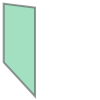

In [22]:
mpa.iloc[0]['Geometry']

In [24]:
a = Polygon([(0,0),(1,0),(0,1)])
b = Polygon([(0,0),(1,1),(1,0)])
c = Polygon([(0,0),(-1,0),(0,-1)])
d = Polygon([(0,3),(0,4),(1,3)])
e = LineString([(-1,1),(-2,2)])
f = Point(1,-1)

In [30]:
f.distance(a)

1.0

# Read Occupation Data

In [2]:
#read NES data
#Nonemp15co.txt
all_nes = pd.DataFrame()
for f in os.listdir('../../data/occupation/nonemployer_stats/csv_files'):
    nes = pd.read_csv('../../data/occupation/nonemployer_stats/csv_files/' + f)
    nes.columns = nes.columns.str.lower()
    #the files don't come with years, so I add it here
    nes['year'] = '20'+f[6:8]
    all_nes = all_nes.append(nes)

#Below are the NAICS codes for industries relevant to this analysis
#311119 Kelp meal and pellets, animal feed manufacturing

#1125 Aquaculture
#11251 Aquaculture
#112511 Finfish Farming and Fish Hatcheries
#112512 Shellfish Farming
#112519 Other Aquaculture

#1141 Fishing
#11411 Fishing
#114111 Finfish Fishing
#114112 Shellfish Fishing
#114119 Other Marine Fishing

#more clarification on a few
#112519 Other Aquaculture
#This U.S. industry comprises establishments primarily engaged in (1) farm raising of aquatic animals
#(except finfish and shellfish) and/or (2) farm raising of aquatic plants. Alligator, algae, frog, seaweed, 
#or turtle production is included in this industry.
#112519 Seaweed farming
#114119 Seaweed gathering

#relevant naics occupation codes
occupations = [311119,1125,11251,112511,112512,112519,11411,114111,114112,114119]

#Read fips codes
fips_codes = pd.read_csv('../../data/occupation/fips_county.csv')

#filter data
all_nes = all_nes.merge(fips_codes, left_on = ["st","cty"], right_on=["fips_state","fips_county"])
all_nes = all_nes[all_nes['State'] == 'CA']
all_nes = all_nes[all_nes['naics'].isin(list(map(str,occupations)))]
all_nes.drop(["st","cty","rcptot_n_f","rcptot_f","rcptot","fips_class_code"], axis=1, \
            inplace=True)
print(all_nes.shape)
all_nes.head()

(562, 8)


,estab,estab_f,naics,year,State,fips_state,fips_county,name
557938,50,NaN,11411,2006,CA,6,1,Alameda County
558406,46,NaN,11411,2007,CA,6,1,Alameda County
558867,58,NaN,11411,2008,CA,6,1,Alameda County
559328,55,NaN,11411,2009,CA,6,1,Alameda County
559791,42,NaN,11411,2010,CA,6,1,Alameda County


In [90]:
#only naics code 11411 is in data for CA
all_nes['naics'].unique()
all_nes.dtypes

estab           int64
estab_f        object
naics          object
year           object
State          object
fips_state      int64
fips_county     int64
name           object
dtype: object

In [112]:
#read qcew data
all_qcew = pd.DataFrame()
for f in os.listdir('../../data/occupation/qcew'):
    qcew = pd.read_csv('../../data/occupation/qcew/'+f)
    qcew = qcew[list(qcew.columns[:10])]
    qcew.drop(['own_code','qtr',], axis=1,inplace=True)
    qcew = qcew[qcew['area_fips'].str.isnumeric()]
    qcew['fips_county'] = qcew['area_fips'].str[-3:].astype(int)
    qcew['fips_state'] = qcew['area_fips'].apply(lambda x: x[:2] if len(x)>4 else x[:1]).astype(int)
    qcew = qcew.merge(fips_codes, on=["fips_state","fips_county"])
    qcew = qcew[qcew['State'] == 'CA']
    all_qcew = all_qcew.append(qcew)
all_qcew.dtypes

area_fips            object
industry_code         int64
agglvl_code           int64
size_code             int64
year                  int64
disclosure_code      object
annual_avg_estabs     int64
annual_avg_emplvl     int64
fips_county           int64
fips_state            int64
State                object
name                 object
fips_class_code      object
dtype: object

# Read in Census Population Data

In [92]:
census = pd.read_csv('../../data/population/co-est2017-alldata.csv',encoding='ISO-8859-1')
census = census[list(census.columns[3:17])]
census.drop(['CENSUS2010POP','ESTIMATESBASE2010'], inplace=True, axis=1)
#rename columns so we can merge datasets
newcolnames = ['2010','2011','2012','2013','2014','2015','2016','2017']
oldcolnames = ['POPESTIMATE'+i for i in newcolnames]
census.rename(columns = dict(zip(oldcolnames,newcolnames)), inplace=True)
census.head()

,STATE,COUNTY,STNAME,CTYNAME,2010,2011,2012,2013,2014,2015,2016,2017
0,1,0,Alabama,Alabama,4785579,4798649,4813946,4827660,4840037,4850858,4860545,4874747
1,1,1,Alabama,Autauga County,54750,55199,54927,54695,54864,54838,55278,55504
2,1,3,Alabama,Baldwin County,183110,186534,190048,194736,199064,202863,207509,212628
3,1,5,Alabama,Barbour County,27332,27351,27175,26947,26749,26264,25774,25270
4,1,7,Alabama,Bibb County,22872,22745,22658,22503,22533,22561,22633,22668


In [93]:
#convert the columns to rows so that we can merge datasets
census = pd.melt(census, id_vars = ['STATE','COUNTY','STNAME','CTYNAME'], var_name='year', value_name='population')
census = census.sort_values(['STATE','COUNTY'])
census.head(10)
census.dtypes

STATE          int64
COUNTY         int64
STNAME        object
CTYNAME       object
year          object
population     int64
dtype: object

In [68]:
#merge the census data with the nes data to get the percent of county workforce in a relevant occupation
all_nes = all_nes.merge(census, left_on=['fips_state','fips_county','year'],\
                        right_on=['STATE', 'COUNTY','year'], how='inner')
all_nes['pct'] = all_nes['estab']/all_nes['population']
all_nes.head()

,estab,estab_f,naics,year,State,fips_state,fips_county,name,STATE,COUNTY,STNAME,CTYNAME,population,pct
0,42,NaN,11411,2010,CA,6,1,Alameda County,6,1,California,Alameda County,1513402,0.000028
1,71,NaN,11411,2011,CA,6,1,Alameda County,6,1,California,Alameda County,1532215,0.000046
2,63,NaN,11411,2012,CA,6,1,Alameda County,6,1,California,Alameda County,1556648,0.000040
3,65,NaN,11411,2013,CA,6,1,Alameda County,6,1,California,Alameda County,1582936,0.000041
4,64,NaN,11411,2014,CA,6,1,Alameda County,6,1,California,Alameda County,1611572,0.000040


In [113]:
#merge census data to qcew data
#convert year to str for comparison
all_qcew['year'] = all_qcew.year.astype(str)
all_qcew = all_qcew.merge(census, left_on=['fips_state','fips_county','year'],\
                          right_on=['STATE','COUNTY','year'], how='inner')
all_qcew['estab_pct'] = all_qcew['annual_avg_estabs']/all_qcew['population']
all_qcew['emp_pct'] = all_qcew['annual_avg_emplvl']/all_qcew['population']
all_qcew.head()

,area_fips,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,fips_county,fips_state,State,name,fips_class_code,STATE,COUNTY,STNAME,CTYNAME,population,estab_pct,emp_pct
0,06007,11251,77,0,2013,N,1,0,7,6,CA,Butte County,H1,6,7,California,Butte County,221768,0.000005,0.000000
1,06015,11251,77,0,2013,N,1,0,15,6,CA,Del Norte County,H1,6,15,California,Del Norte County,27830,0.000036,0.000000
2,06015,11411,77,0,2013,NaN,39,81,15,6,CA,Del Norte County,H1,6,15,California,Del Norte County,27830,0.001401,0.002911
3,06019,11251,77,0,2013,N,4,0,19,6,CA,Fresno County,H1,6,19,California,Fresno County,953787,0.000004,0.000000
4,06023,11251,77,0,2013,NaN,6,19,23,6,CA,Humboldt County,H1,6,23,California,Humboldt County,134444,0.000045,0.000141


# Read County shapefiles

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,6,75,00277302,0500000US06075,06075,San Francisco,06,121485107,479107241,"POLYGON ((-122.511983 37.77113, -122.465396 37..."
1,25,25,00606939,0500000US25025,25025,Suffolk,06,150855462,160479920,"POLYGON ((-71.19115499999999 42.283059, -71.15..."
2,31,7,00835826,0500000US31007,31007,Banner,06,1932676697,397069,"POLYGON ((-104.052825235239 41.69795385306401,..."
3,37,181,01008591,0500000US37181,37181,Vance,06,653705784,42187365,"POLYGON ((-78.497783 36.514477, -78.4572778962..."
4,48,421,01383996,0500000US48421,48421,Sherman,06,2390651189,428754,"POLYGON ((-102.162463 36.500326, -102.03233901..."


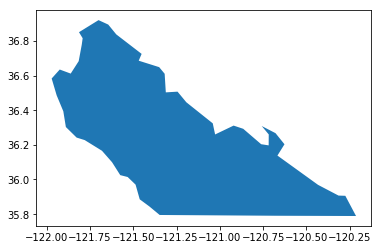

In [30]:
counties = gpd.read_file('../../data/county_shapefiles/cb_2017_us_county_20m/cb_2017_us_county_20m.shp')
counties['STATEFP'] = counties['STATEFP'].astype(int)
counties['COUNTYFP'] = counties['COUNTYFP'].astype(int)
counties[(counties['STATEFP']==6) & (counties.COUNTYFP == 53)]['geometry'].plot()
counties.head()

In [31]:
fips_codes.head()
print(fips_codes[fips_codes['State']=='CA']['fips_state'].unique())
ca_counties = counties[counties['STATEFP'] == int(fips_codes[fips_codes['State']=='CA']['fips_state'].unique())]
counties.head()

[6]


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,6,75,00277302,0500000US06075,06075,San Francisco,06,121485107,479107241,"POLYGON ((-122.511983 37.77113, -122.465396 37..."
1,25,25,00606939,0500000US25025,25025,Suffolk,06,150855462,160479920,"POLYGON ((-71.19115499999999 42.283059, -71.15..."
2,31,7,00835826,0500000US31007,31007,Banner,06,1932676697,397069,"POLYGON ((-104.052825235239 41.69795385306401,..."
3,37,181,01008591,0500000US37181,37181,Vance,06,653705784,42187365,"POLYGON ((-78.497783 36.514477, -78.4572778962..."
4,48,421,01383996,0500000US48421,48421,Sherman,06,2390651189,428754,"POLYGON ((-102.162463 36.500326, -102.03233901..."


# Read XBT bathymetry data

In [6]:
xbt = pd.read_csv('../../data/bathymetry/xbt/ca/xbts7412.csv')
xbt.append(pd.read_csv('../../data/bathymetry/xbt/ca/xbts7312.csv'))
xbt.append(pd.read_csv('../../data/bathymetry/xbt/ca/xbts7311.csv'))

,ISO_country,Cruise_ID,Latitude,Longitude,Year,Month,Day,Time,WOD_unique,Temp_0m,...,Temp_8100m,Temp_8200m,Temp_8300m,Temp_8400m,Temp_8500m,Temp_8600m,Temp_8700m,Temp_8800m,Temp_8900m,Temp_9000m
0,US,44081,46.830,-129.920,1967,9,2,6.03,2059188,18.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US,44081,48.130,-125.680,1967,9,2,17.67,2059198,16.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US,41129,40.570,-125.920,1967,12,7,11.50,3417034,13.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US,41129,40.620,-125.900,1967,12,7,16.00,2063364,12.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US,41129,41.650,-126.130,1967,12,7,18.00,2063366,13.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,US,41129,44.330,-126.430,1967,12,8,5.50,2063381,11.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,US,41129,45.820,-125.620,1967,12,8,11.50,3417048,10.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,US,41129,47.370,-124.950,1967,12,8,15.50,3417050,10.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,US,40526,48.930,-127.800,1968,2,23,2.00,2065380,6.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,US,40526,48.680,-126.200,1968,2,23,10.00,2065391,8.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
xbt.head()

,ISO_country,Cruise_ID,Latitude,Longitude,Year,Month,Day,Time,WOD_unique,Temp_0m,...,Temp_8100m,Temp_8200m,Temp_8300m,Temp_8400m,Temp_8500m,Temp_8600m,Temp_8700m,Temp_8800m,Temp_8900m,Temp_9000m
0,US,44081,46.83,-129.92,1967,9,2,6.03,2059188,18.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US,44081,48.13,-125.68,1967,9,2,17.67,2059198,16.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US,41129,40.57,-125.92,1967,12,7,11.50,3417034,13.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US,41129,40.62,-125.90,1967,12,7,16.00,2063364,12.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US,41129,41.65,-126.13,1967,12,7,18.00,2063366,13.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
xbt_recent = xbt[xbt['Year'] > 2005]
xbt.shape

(23488, 146)

In [10]:
ca_xbt = xbt_recent[(xbt_recent['Latitude'] <42.5) & (xbt_recent['Latitude']>32)\
                    & (xbt_recent['Longitude'] <-116.3) & (xbt_recent['Longitude'])>-124.5]
ca_xbt.shape

(1124, 146)

In [12]:
ca_xbt.head()

,ISO_country,Cruise_ID,Latitude,Longitude,Year,Month,Day,Time,WOD_unique,Temp_0m,...,Temp_8100m,Temp_8200m,Temp_8300m,Temp_8400m,Temp_8500m,Temp_8600m,Temp_8700m,Temp_8800m,Temp_8900m,Temp_9000m
22364,US,27600,48.466,-129.184,2006,1,1,5.87,10731590,10.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22365,US,28415,48.449,-129.683,2006,1,6,17.18,10731718,9.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22366,US,28415,48.460,-128.237,2006,1,6,20.17,10731721,10.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22367,CA,18509,49.033,-123.467,2006,2,13,22.75,12278447,7.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22368,CA,18509,49.333,-124.000,2006,2,14,4.23,12278448,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
temps = ca_xbt[list(ca_xbt.columns[9:])]
#qcew = qcew[list(qcew.columns[:10])]
print(temps.iloc[0])
np.gradient(np.gradient(temps.iloc[0]))

Temp_0m       10.18
Temp_5m       10.15
Temp_10m      10.15
Temp_15m      11.43
Temp_20m      11.15
Temp_25m      10.93
Temp_30m      10.77
Temp_35m      10.77
Temp_40m      10.84
Temp_45m      10.72
Temp_50m      10.44
Temp_55m       9.93
Temp_60m       9.31
Temp_65m       8.60
Temp_70m       8.50
Temp_75m       8.39
Temp_80m        NaN
Temp_85m        NaN
Temp_90m        NaN
Temp_95m        NaN
Temp_100m       NaN
Temp_125m       NaN
Temp_150m       NaN
Temp_175m       NaN
Temp_200m       NaN
Temp_225m       NaN
Temp_250m       NaN
Temp_275m       NaN
Temp_300m       NaN
Temp_325m       NaN
              ...  
Temp_6100m      NaN
Temp_6200m      NaN
Temp_6300m      NaN
Temp_6400m      NaN
Temp_6500m      NaN
Temp_6600m      NaN
Temp_6700m      NaN
Temp_6800m      NaN
Temp_6900m      NaN
Temp_7000m      NaN
Temp_7100m      NaN
Temp_7200m      NaN
Temp_7300m      NaN
Temp_7400m      NaN
Temp_7500m      NaN
Temp_7600m      NaN
Temp_7700m      NaN
Temp_7800m      NaN
Temp_7900m      NaN


array([ 0.015 ,  0.335 ,  0.2575, -0.445 , -0.345 ,  0.085 ,  0.1125,
        0.0275, -0.1175, -0.185 , -0.1825, -0.135 ,  0.08  ,  0.28  ,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     